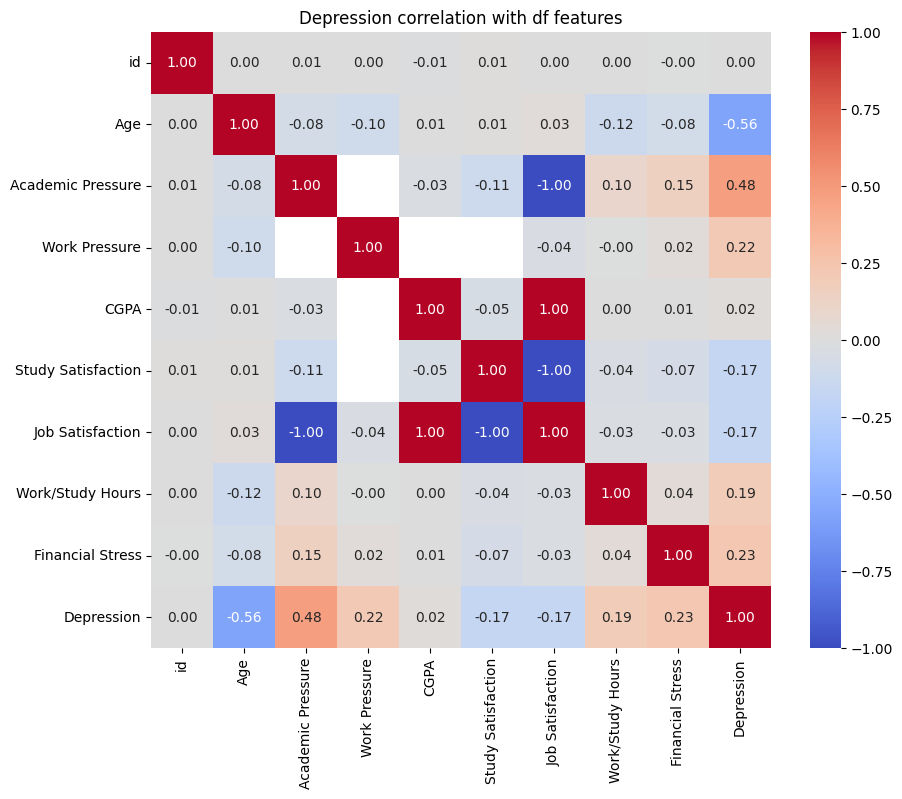

In [111]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn . tree import DecisionTreeRegressor
from sklearn . ensemble import RandomForestRegressor
from sklearn . model_selection import train_test_split
import seaborn as sns 
import matplotlib . pyplot as plt


# lets read the data -------------------------------------------------------------------------
initial_df = pd . read_csv( '/kaggle/input/playground-series-s4e11/train.csv' )
exclusive_test_df = pd . read_csv( '/kaggle/input/playground-series-s4e11/train.csv' )

# lets filter only the numeric data ---------------------------
numeric_df = initial_df . select_dtypes( include = [ np . number ] )


# before going to any direction lets look upon some qualitative data analysis so we can establish which parameters are the most influential ones
# generating the heat map on the numeric data_frame
depression_correlation_matrix = numeric_df . corr()
plt . figure( figsize = (10,8) )
sns . heatmap( depression_correlation_matrix , annot = True , fmt = ".2f" , cmap = 'coolwarm' )
plt . title( "Depression correlation with df features" )
plt . show()
# using gradients this is good for visual inspection of the data
# based on all of the features keys to see which one has the most influence
#how data looks
#exclusive_test_df . describe()
#initial_df . describe()

whats interesting here is to see that there are strong correlations even with non even parameters

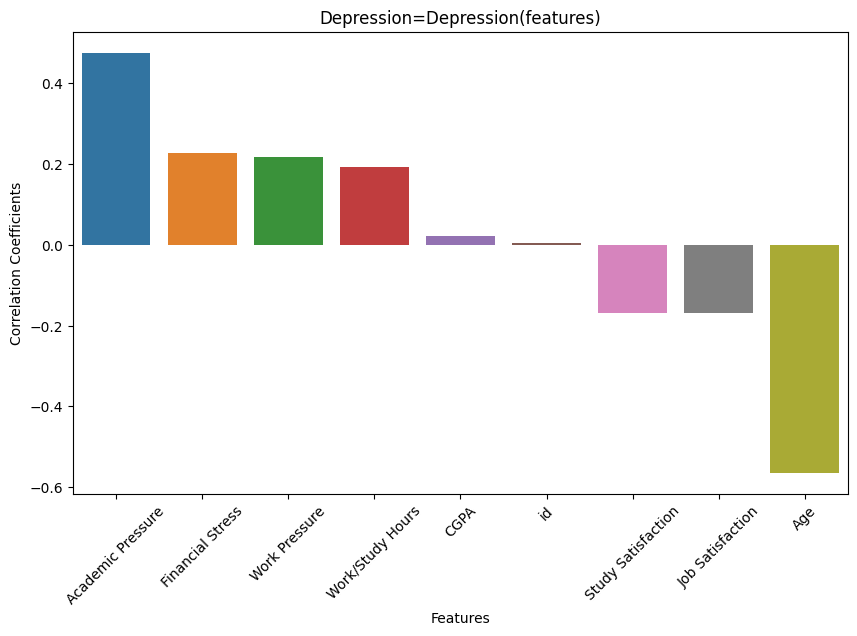

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


In [112]:
# now to see whats the correlation with strictly depression
correlation_with_depresion = numeric_df.corr()["Depression"] . dropna()
correlation_with_depresion = correlation_with_depresion . drop( 'Depression' )
# sorting from strong to weak dependence
sorted_correlation = correlation_with_depresion . sort_values( ascending = False )
# creating bar plot
plt . figure( figsize = ( 10 , 6 ) )
sns . barplot( x = sorted_correlation.index , y = sorted_correlation . values )
plt . xticks( rotation = 45 )
plt . title( "Depression=Depression(features)" )
plt . xlabel( "Features" )
plt . ylabel( "Correlation Coefficients" )
plt . show()
initial_df . describe()

In [113]:
# constructing a list of key fields
relevant_fields = [ 'Age', 'Job Satisfaction', 'Study Satisfaction', 
              'Work/Study Hours', 'Work Pressure', 'Financial Stress', 
              'Academic Pressure' ]
# creating a data frame child with the relevant fields
relevant_fields_df = initial_df[ relevant_fields ]
missing_values = relevant_fields_df . isnull() . sum()
total_entries = relevant_fields_df . shape[0]
missing_percentage = ( missing_values / total_entries ) * 100
missing_summary = pd . DataFrame( {
    'Missing Values' : missing_values,
    'Percentage Missing' : missing_percentage
} )
print( missing_summary )
# lets see the students 
counts_workers_students = initial_df[ 'Working Professional or Student' ] . value_counts()
students_No = counts_workers_students . get( "Student" , 0 )
professionals_No = counts_workers_students . get( "Working Professional" , 0 )
print( "Students number: " , students_No )
print( "Professionals number: " , professionals_No )

                    Missing Values  Percentage Missing
Age                              0            0.000000
Job Satisfaction             27910           19.836532
Study Satisfaction          112803           80.172708
Work/Study Hours                 0            0.000000
Work Pressure                27918           19.842217
Financial Stress                 4            0.002843
Academic Pressure           112803           80.172708
Students number:  27901
Professionals number:  112799


In [114]:
#lets see the data types 
initial_df . dtypes

id                                         int64
Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

In [115]:
from sklearn.impute import SimpleImputer

# Filter only numeric columns with float type in initial_df
numerical_features = initial_df.select_dtypes(include=['float64']).columns

# Creating an instance of SimpleImputer and applying it to the DataFrame's numeric columns
simple_imputer = SimpleImputer(strategy='mean')
initial_df[numerical_features] = simple_imputer.fit_transform(initial_df[numerical_features])

# Checking if there are still missing values
print(initial_df.isnull().sum())

id                                           0
Name                                         0
Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                               36630
Academic Pressure                            0
Work Pressure                                0
CGPA                                         0
Study Satisfaction                           0
Job Satisfaction                             0
Sleep Duration                               0
Dietary Habits                               4
Degree                                       2
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             0
Family History of Mental Illness             0
Depression                                   0
dtype: int64


In [116]:
# preparing the data for model fitting
from sklearn . model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn . metrics import classification_report , confusion_matrix

# constructing X and y collections
X = initial_df[['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 
         'Study Satisfaction', 'Job Satisfaction', 
         'Work/Study Hours', 'Financial Stress']]  # relevant features observed
y = initial_df['Depression']  # the target
# splitting my training and testing data
X_train , X_test , y_train , y_test = train_test_split( X , y , test_size = 0.2 , random_state = 42 )
# making the model
model = XGBClassifier( use_label_encoder = False , eval_metric = 'logloss' )
model . fit( X_train , y_train )
# predictions:
y_predictions = model . predict( X_test )

print( "Confusion matrix: " )
print( confusion_matrix( y_test , y_predictions ) )
print( "\n Classification report: " )
print( classification_report( y_test , y_predictions ) )
# an average precission of 92%

Confusion matrix: 
[[21972  1014]
 [ 1234  3920]]

 Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     22986
           1       0.79      0.76      0.78      5154

    accuracy                           0.92     28140
   macro avg       0.87      0.86      0.86     28140
weighted avg       0.92      0.92      0.92     28140



In [117]:
# as data seem very categorical it would be a good idea to go with the CATboost since is optimized for very independent features
# again lets see the structure of data
initial_df . describe()
categorical_columns_wanna_bes = [ 'Academic Pressure' , 'Work Pressure' , 'Study Satisfaction' , 'Job Satisfaction' ,
                                  'Work/Study Hours' , 'Financial Stress' ]

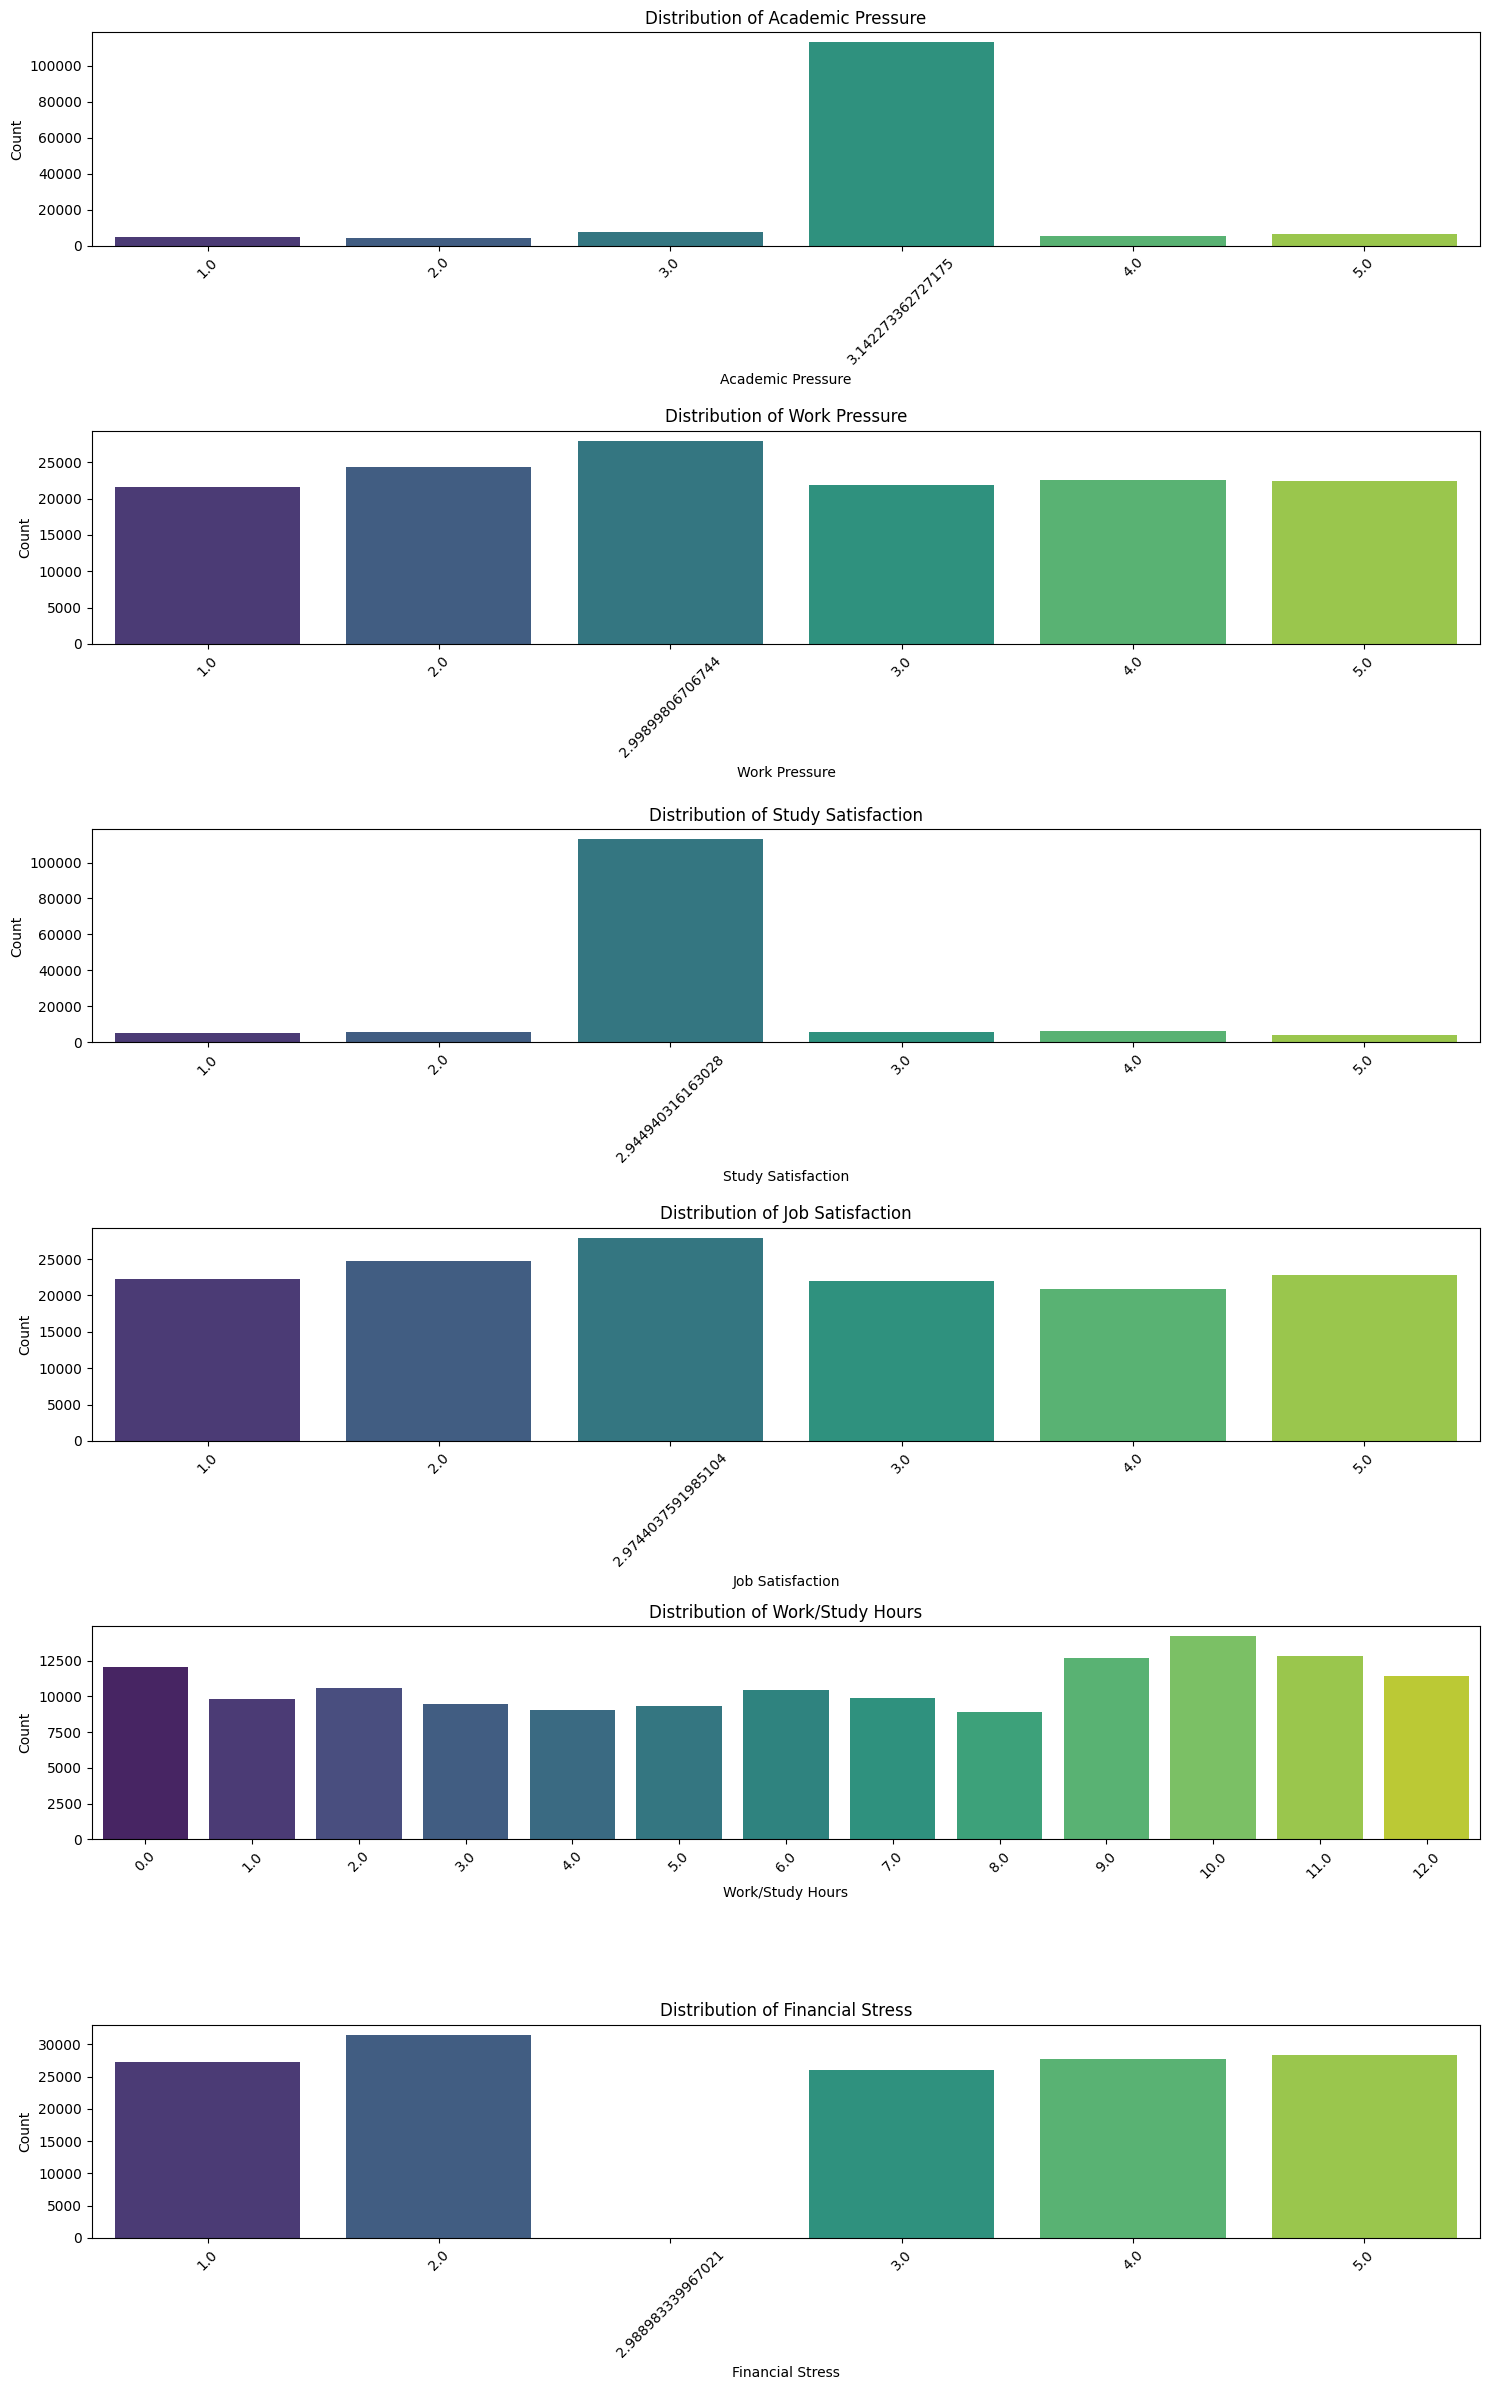

In [118]:
# see how it behaves with catboost
from catboost import CatBoostClassifier, Pool
from sklearn . model_selection import train_test_split
import matplotlib . pyplot as plt
import seaborn as sns
# Set up the figure size and grid layout
plt.figure(figsize=(15, len(categorical_columns_wanna_bes) * 4))  # Adjust figure height based on the number of plots

# Loop through each column and plot
for i, column in enumerate(categorical_columns_wanna_bes, 1):
    plt.subplot(len(categorical_columns_wanna_bes), 1, i)  # Define the grid for subplots
    sns.countplot(data=initial_df, x=column, palette='viridis')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-ticks if necessary for better readability

plt.tight_layout()
plt.show()


In [119]:
categorical_df = initial_df
for column in categorical_columns_wanna_bes:
    categorical_df[column] = categorical_df[column].round()
for column in categorical_columns_wanna_bes:
    categorical_df[column] = categorical_df[column] . astype(int)
        

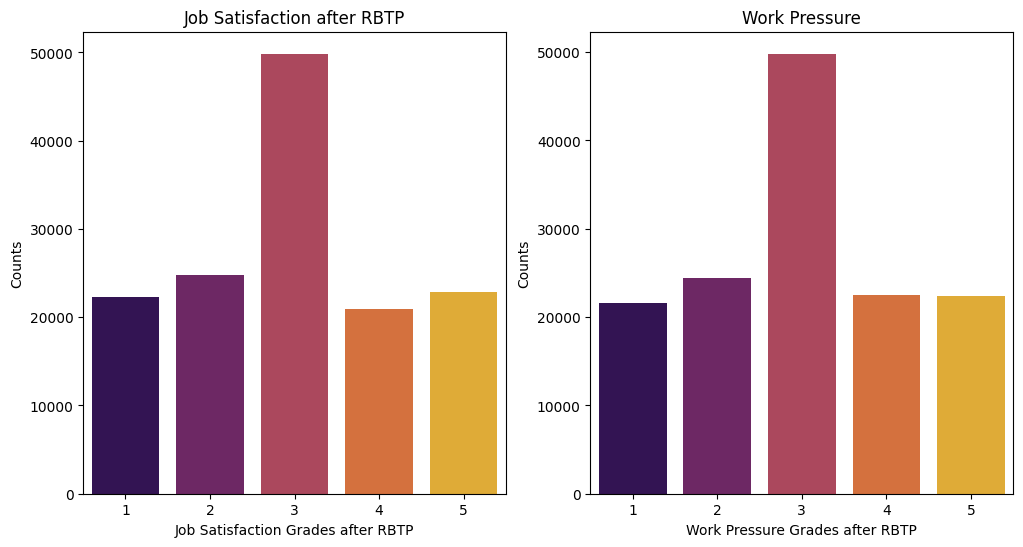

In [120]:
fig_RBTP , axes_RBTP = plt . subplots( nrows = 1 , ncols = 2 , figsize = ( 12 , 6 ) )
# lets see some of the new data
sns.countplot(data=categorical_df, x='Job Satisfaction', palette='inferno', ax=axes_RBTP[0])
axes_RBTP[0] . set_title( 'Job Satisfaction after RBTP' )
axes_RBTP[0] . set_xlabel( 'Job Satisfaction Grades after RBTP' )
axes_RBTP[0] . set_ylabel( 'Counts' )

sns . countplot( data = categorical_df , x = 'Work Pressure' , palette = 'inferno' , ax = axes_RBTP[1] )
axes_RBTP[1] . set_title( 'Work Pressure' )
axes_RBTP[1] . set_xlabel( 'Work Pressure Grades after RBTP' )
axes_RBTP[1] . set_ylabel( 'Counts' )

plt . show()

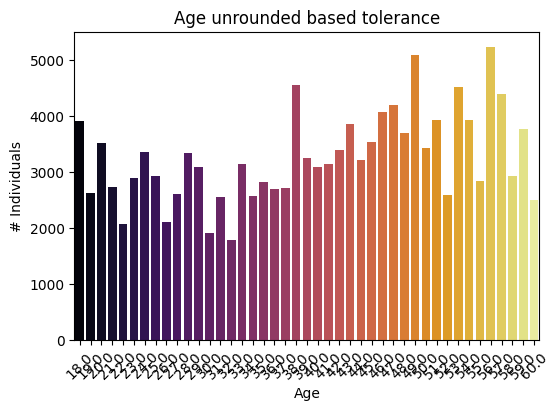

In [121]:
plt . figure( figsize = ( 6 , 4 ) )
sns . countplot( data = categorical_df , x = 'Age' , palette = 'inferno' )
plt . title( 'Age unrounded based tolerance' )
plt . xlabel( 'Age' )
plt . ylabel( '# Individuals' )
plt . xticks( rotation = 45)
plt  . show()

By the looks of it age clearly can be treated as categorical

In [122]:
# to make sure that we have everything ready for categorical ill round every relevant feature of the model
categorical_df[ relevant_fields ] = categorical_df[ relevant_fields ] . round() . astype( int )
# now to verify our changes
print( categorical_df[ relevant_fields ] . dtypes )
print( categorical_df[ relevant_fields ] . head() )

Age                   int64
Job Satisfaction      int64
Study Satisfaction    int64
Work/Study Hours      int64
Work Pressure         int64
Financial Stress      int64
Academic Pressure     int64
dtype: object
   Age  Job Satisfaction  Study Satisfaction  Work/Study Hours  Work Pressure  \
0   49                 2                   3                 1              5   
1   26                 3                   3                 7              4   
2   33                 3                   2                 3              3   
3   22                 1                   3                10              5   
4   30                 1                   3                 9              1   

   Financial Stress  Academic Pressure  
0                 2                  3  
1                 3                  3  
2                 1                  5  
3                 1                  3  
4                 4                  3  


In [123]:
print ( categorical_df[ relevant_fields ] . dtypes )
for col in relevant_fields:
    if categorical_df[col].apply(lambda x: isinstance(x, float)).any():
        print(f"Column {col} still has floats.")
print( "No float64 lingering " )
print(X_train.columns)  # Check the order of the columns in X_train
print( categorical_df . columns )

Age                   int64
Job Satisfaction      int64
Study Satisfaction    int64
Work/Study Hours      int64
Work Pressure         int64
Financial Stress      int64
Academic Pressure     int64
dtype: object
No float64 lingering 
Index(['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
       'Financial Stress'],
      dtype='object')
Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')


In [ ]:
# looks good ready to implement CATboost
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
categorical_X = categorical_df[ relevant_fields ]
categorical_y = categorical_df[ 'Depression' ]
cat_X_train , cat_X_test , cat_y_train , cat_y_test = train_test_split( categorical_X , categorical_y , test_size = 0.2 , random_state = 42 )

from catboost import Pool, cv
from sklearn.metrics import log_loss, accuracy_score, f1_score, roc_auc_score

# Define the training pool with categorical features specified
train_pool = Pool(data=cat_X_train, label=cat_y_train, cat_features=[0, 1, 2, 3, 4, 5, 6])

# Set up cross-validation parameters
params = {
    'iterations': 5000,
    'depth': 6,
    'learning_rate': 0.01,
    'loss_function': 'Logloss',
    'early_stopping_rounds': 100,
    'verbose': 100,
}

# Run cross-validation
cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=5,
    plot=True  # if you want to see a plot of the CV results
)

# Best iteration determined from cross-validation
best_iteration = cv_results['iterations'].idxmin()
if best_iteration <= 0:
    print("Cross-validation did not yield a positive best iteration. Using default iterations.")
    best_iteration = 1000  # Set a reasonable default

# Fit the model with the best (or default) iteration count
CBmodel = CatBoostClassifier(
    iterations=best_iteration,
    depth=6,
    learning_rate=0.01,
    loss_function='Logloss',
    cat_features=[0, 1, 2, 3, 4, 5, 6],
    verbose=100
)

CBmodel.fit(cat_X_train, cat_y_train)

# Predict probabilities for log loss
pred_prob = CBmodel.predict_proba(cat_X_test)
log_loss_value = log_loss(cat_y_test, pred_prob)

# Standard accuracy metrics for evaluation
predictions = CBmodel.predict(cat_X_test)
CBaccuracy = accuracy_score(cat_y_test, predictions)
CBf1 = f1_score(cat_y_test, predictions, average='weighted')
CBroc_auc = roc_auc_score(cat_y_test, pred_prob[:,1])

print(f"Log Loss: {log_loss_value}")
print(f"Accuracy: {CBaccuracy}")
print(f"F1 Score: {CBf1}")
print(f"ROC-AUC Score: {CBroc_auc}")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.6838995	test: 0.6838586	best: 0.6838586 (0)	total: 94.8ms	remaining: 7m 54s


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
from sklearn.impute import SimpleImputer
import pandas as pd

# Load and preprocess the test data
test_df = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')

test_df . describe()

test_df["Dietary Habits"] = test_df["Dietary Habits"].where(
    test_df["Dietary Habits"].isin(["Healthy", "Unhealthy", "Moderate"]), pd.NA
)
test_df = test_df.dropna(subset=['Dietary Habits'])

# Impute missing values in numerical columns
test_numerical_cols = test_df.select_dtypes(include=['float64', 'int64']).columns
testImputer = SimpleImputer(strategy='mean')
test_df[test_numerical_cols] = testImputer.fit_transform(test_df[test_numerical_cols])

# Round and convert relevant fields to integer type for CatBoost compatibility
test_df[relevant_fields] = test_df[relevant_fields].round().astype(int)

# Prepare features for testing
test_test_X = test_df[relevant_fields]

# Predict the target values and probabilities for test set
test_predictions = CBmodel.predict(test_test_X)
test_predictions_prob = CBmodel.predict_proba(test_test_X)[:, 1]  # Probability of the positive class
'''
# If you have the true labels for test data, calculate evaluation metrics
if 'Depression' in test_df.columns:
    cat_y_test = test_df['Depression']  # True labels for the test data

    # Evaluate the model
    accuracy = accuracy_score(cat_y_test, test_predictions)
    f1 = f1_score(cat_y_test, test_predictions)
    roc_auc = roc_auc_score(cat_y_test, test_predictions_prob)
    logloss = log_loss(cat_y_test, test_predictions_prob)

    # Print evaluation results
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC Score: {roc_auc}")add Code￼add Markdown
    print(f"Log Loss: {logloss}")
else:
    print("True labels are not available for this test dataset.")'''


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stats
import numpy as np

# Convert categorical variables to numerical using OneHotEncoder
encoder = OneHotEncoder(drop='first')  # Drop first to avoid multicollinearity
encoded_features = encoder.fit_transform(categorical_df[['Sleep Duration', 'Dietary Habits', 'Family History of Mental Illness']]).toarray()

# Create a DataFrame for the encoded features
predictions = CBmodel . predict( cat_X_test )
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Sleep Duration', 'Dietary Habits', 'Family History of Mental Illness']))

# Concatenate the encoded features with the target variable
df_encoded = pd.concat([encoded_df, categorical_df['Depression']], axis=1)

# Calculate the correlation matrix using Pearson for numerical encoded data
correlation_matrix = df_encoded.corr()  # Pearson's correlation
def cramers_v(x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)
    
    # Chi-squared test
    chi2, p, dof, expected = stats.chi2_contingency(ly included and has no valid syntax in Python.

Removing or commenting out this line should resolve the issue:

python
￼Copy codev
contingency_table)
    
    # Cramér's V calculation
    n = contingency_table.sum().sum()  # Total number of observations
    k = min(contingency_table.shape)   # Number of categories in the smaller variable
    v = np.sqrt(chi2 / (n * (k - 1)))
    
    return v

# Calculate Cramér's V for 'Family History of Mental Illness' and 'Depression'
cramers_family_history = cramers_v(categorical_df['Family History of Mental Illness'], categorical_df['Depression'])
print(f"Cramér's V between 'Family History of Mental Illness' and 'Depression': {cramers_family_history}")

# Calculate Cramér's V for 'Sleep Duration' and 'Depression'
cramers_sleep_duration = cramers_v(categorical_df['Slely included and has no valid syntax in Python.

Removing or commenting out this line should resolve the issue:

python
￼Copy covde
ep Duration'], categorical_df['Depression'])
print(f"Cramér's V between 'Sleep Duration' and 'Depression': {cramers_sleep_duration}")

# Calculate Cramér's V for 'Dietary Habits' and 'Depression'
cramers_dietary_habits = cramers_v(categorical_df['Dietary Habits'], categorical_df['Depression'])
print(f"Cramér's V between 'Dietary Habits' and 'Depression': {cramers_dietary_habits}")

In [ ]:
# so i dont observe much correlation with the Familiy illness history and Sleep Duration , Dietary habits is tho
# lets investigate furhter
# lets see the datatype
categorical_df['Dietary Habits'] . describe()
dietary_expected_marks = ["Healthy" , "Unhealthy" , "Moderate"]
dietary_unexpected_marks = categorical_df['Dietary Habitsly included and has no valid syntax in Python.

Removing or commenting out this line should resolve the issue:

python
￼Copy code
'][~categorical_df['Dietary Habits'] . isin( dietary_expected_marks )] . unique()
#print( f"Values that are appart: {dietary_unexpected_marks}" )
# looks bad i have to clean aly included and has no valid syntax in Python.

Removing or commenting out this line should resolve the issue:

python
￼Copy code
 little bit
categorical_df['Dietary Habits'] = categorical_df['Dietary Habits'].where(
    categorical_df['Dietary Habits'].isin(["Healthy", "Unhealthy", "Moderate"]), np.nan
)

# Drop rows with NaN in 'Dietary Habits'
categorical_df = categorical_df.dropna(subset=['Dietary Habits'])
# check again
#dietary_unexpected_marks = categorical_df['Dietary Habits'][~categorical_df['Dietary Habits'] . isin( dietary_expected_marks )] . unique()
#print( f"Values that are off again: {dietary_unexpected_marks}" )
#lets see how many nans now

